In [3]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rc
%matplotlib inline
plt.style.use("ggplot")

import daft
from gensim.models.doc2vec import Word2Vec
import json
from IPython.display import SVG, display
import numpy as np
np.random.seed(13)

from keras import backend as K
from keras.models import Model, Sequential, model_from_json
from keras.datasets import mnist, cifar10, imdb
from keras.layers import Dense, Dropout, Activation, Flatten, Embedding, LSTM, GRU, Input, RepeatVector, TimeDistributed, Merge, Lambda, Reshape
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import Adadelta
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.utils.visualize_util import model_to_dot, plot
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, base_filter

In [7]:
import keras
import six

データの読み込み

In [22]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [6]:
nb_classes = 10
input_unit_size = 28 * 28

In [8]:
def draw_digit(data, row, col, n):
    plt.subplot(row, col, n)
    plt.imshow(data)
    plt.gray()

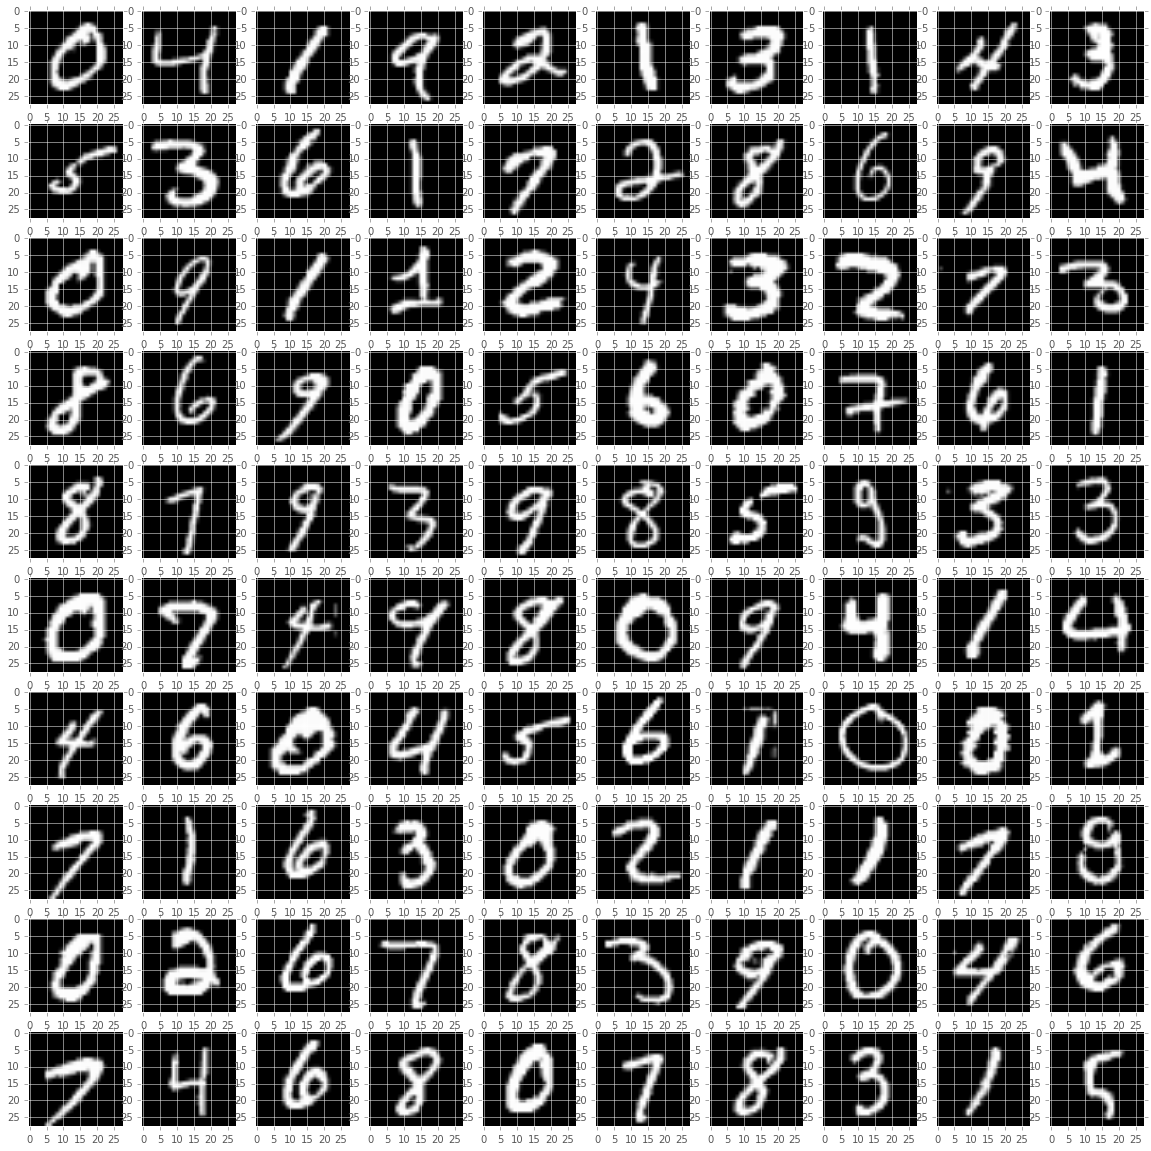

In [9]:
show_size = 10
total = 1
plt.figure(figsize=(20, 20))
for i in six.moves.range(show_size):
    for j in six.moves.range(show_size):
        draw_digit(x_train[total], show_size, show_size, total)
        total += 1
plt.show()

前処理

In [11]:
x_train.shape

(60000, 28, 28)

In [23]:
x_train = x_train.reshape(x_train.shape[0], input_unit_size).astype('float32')
x_test = x_test.reshape(x_test.shape[0], input_unit_size).astype('float32')
x_train /= 255
x_test /= 255

In [24]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [25]:
y_train = keras.utils.np_utils.to_categorical(y_train, nb_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, nb_classes)

In [27]:
y_train[0]

array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.])

モデル定義

In [28]:
model = Sequential()
model.add(Dense(128, input_dim=input_unit_size, init='glorot_uniform'))
model.add(Activation('relu'))
model.add(Dropout(p=0.2))
model.add(Dense(nb_classes, init='glorot_uniform'))
model.add(Activation('softmax'))

functional api

In [29]:
inputs = Input(shape=(input_unit_size,))
x = Dense(128, activation='relu')(inputs)
x = Dropout(0.2)(x)
outputs = Dense(nb_classes, activation='softmax')(x)
model = Model(input=inputs, output=outputs)

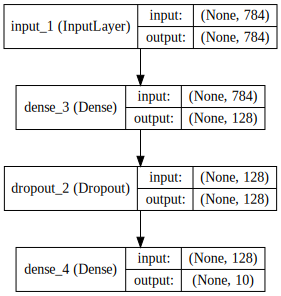

In [30]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## 最適化

In [31]:
optimizer = Adadelta()

## 学習

モデルの記述と最適化の定義が完了したら, 次にモデルのコンパイルを行う.

In [33]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [41]:
nb_epoch = 5
result = model.fit(x_train, y_train, nb_epoch=nb_epoch, batch_size=256, verbose=2, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
1s - loss: 0.1455 - acc: 0.9589 - val_loss: 0.1289 - val_acc: 0.9624
Epoch 2/5
1s - loss: 0.1364 - acc: 0.9614 - val_loss: 0.1235 - val_acc: 0.9643
Epoch 3/5
1s - loss: 0.1307 - acc: 0.9626 - val_loss: 0.1196 - val_acc: 0.9660
Epoch 4/5
1s - loss: 0.1251 - acc: 0.9648 - val_loss: 0.1152 - val_acc: 0.9667
Epoch 5/5
1s - loss: 0.1196 - acc: 0.9657 - val_loss: 0.1125 - val_acc: 0.9676


In [42]:
score = model.evaluate(x_test, y_test, batch_size=256)
print ''
print "test loss:%s" % score[0]
print "test acc:%s" % score[1]

 9728/10000 [============================>.] - ETA: 0s
test loss:0.106910087958
test acc:0.9676


## epochごとのlossとaccuracyの可視化

学習後, result.historyからモデルパラメータやepochごとのloss, accurcyを呼ぶことができる.

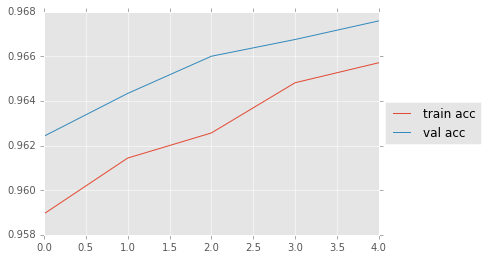

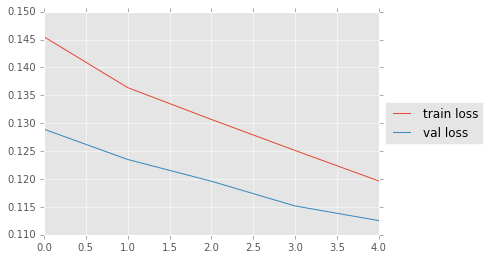

In [43]:
x = range(nb_epoch)
plt.plot(x, result.history['acc'], label='train acc')
plt.plot(x, result.history['val_acc'], label='val acc')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.plot(x, result.history['loss'], label='train loss')
plt.plot(x, result.history['val_loss'], label='val loss')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## モデルの保存と読み込み

モデルファイルはjsonかyamlで, モデルパラメータはHDF5で保存と読み込みが可能.
モデルロードを行う際は,
1. モデルファイルの読み込み
2. パラメータファイルを読み込み, モデルに代入
3. compile

の手順で行う.

In [44]:
with open('mnist_model.json', 'w') as f:
    json.dump(model.to_json(), f)

model.save_weights('mnist_weights.h5')

モデルロード

In [45]:
# load model
mnist_model = model_from_json(json.load(open('mnist_model.json')))

# load weights
mnist_model.load_weights('./mnist_weights.h5')
mnist_model.compile(loss='categorical_crossentropy', optimizer='adadelta')

# Cifar 10でCNN

## データ

In [46]:
batch_size = 256
nb_classes = 10
nb_epoch = 5
nb_filter = 10

img_rows, img_cols = 32, 32
img_channels = 3

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print 'x_train shape: %s' % x_train.shape
print '%s train samples' % x_train.shape[0]
print '%s test samples' % x_test.shape[0]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train = keras.utils.np_utils.to_categorical(y_train, nb_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, nb_classes)

    16384/170498071 [..............................] - ETA: 5988s

KeyboardInterrupt: 